# Model selection using information criteria

author: Audrey Olivier

Theory background: model selection refers to the task of selecting a statistical model from a set of candidate models, given some data. A good model is amodel that is able to explain the data well (high model evidence). Given models of same explanatory power, the simplest model should be chosen (Ockam razor). Several simple criteria can be used to compute a model's quality and thus perform model selection. UQpy implements three citeria: 
<br>
Bayesian information criterion (BIC)
$$ BIC = ln(n) k - 2 ln(\hat{L}) $$

Akaike information criterion (AIC)
$$ AIC = 2 k - 2 ln (\hat{L})  $$

Corrected formula for AIC (AICc), for small data sets 
$$ AICc = AIC + \frac{2k(k+1)}{n-k-1} $$

For all formula above, $k$ is the number of parameters characterizing the model, $\hat{L}$ is the maximum value of the likelihood function and $n$ the number of data points. The best model is the one that minimizes the cirterion. All three formulas have a model fit term (find the model that minimizes the negative log likelihood) and a penalty term that increases as the number of model parameters (model complexity) increases.

Reference: *Burnham, K. P.; Anderson, D. R. (2002), Model Selection and Multimodel Inference: A Practical Information-Theoretic Approach (2nd ed.), Springer-Verlag, ISBN 0-387-95364-7*

## Example 1: selection between different distributions

In [ ]:
# import the required packages
from UQpy.Inference import InfoModelSelection
from UQpy.Inference import ModelClass
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Generate data using one model a gamma distribution with shape 1, same as exponential
from scipy.stats import gamma
data = gamma(a = 2, loc = 0, scale = 1).rvs(size=200)

UQpy: Running Informative model selection for candidate model: exponential
UQpy: Running Informative model selection for candidate model: gamma
UQpy: Running Informative model selection for candidate model: chisquare
UQpy: Informative model selection analysis completed!
Sorted model using BIC criterion: chisquare, gamma, exponential
UQpy: Running Informative model selection for candidate model: exponential
UQpy: Running Informative model selection for candidate model: gamma
UQpy: Running Informative model selection for candidate model: chisquare
UQpy: Informative model selection analysis completed!
Sorted model using AIC criterion: chisquare, gamma, exponential
UQpy: Running Informative model selection for candidate model: exponential
UQpy: Running Informative model selection for candidate model: gamma
UQpy: Running Informative model selection for candidate model: chisquare
UQpy: Informative model selection analysis completed!
Sorted model using AICc criterion: chisquare, gamma, expone

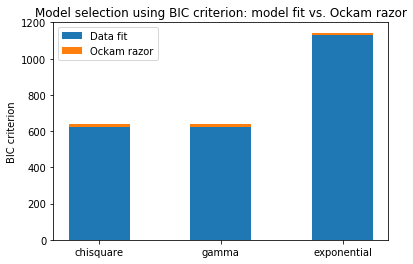

Shape parameter of the gamma distribution: 1.7426913458547013
DoF of the chisquare distribution: 3.485493596089047


In [3]:
# Define the models to be compared
models = ['exponential', 'gamma', 'chisquare']

# Perform model selection using different information criteria
criteria = ['BIC', 'AIC', 'AICc']
for criterion in criteria:
    selector = InfoModelSelection(data = data, candidate_model = models, method = criterion)
    print('Sorted model using '+criterion+' criterion: '+', '.join(x for x in selector.sorted_model))
    if criterion == 'BIC':
        criterion_value = selector.BIC
        data_fit_value = selector.data_fit_value
        sorted_models = selector.sorted_model
        param = selector.Parameters
        
width = 0.5
ind = np.arange(len(sorted_models))
p1 = plt.bar(ind, data_fit_value, width = width)
p2 = plt.bar(ind, criterion_value-data_fit_value, bottom=data_fit_value, width = width)

plt.ylabel('BIC criterion')
plt.title('Model selection using BIC criterion: model fit vs. Ockam razor')
plt.xticks(ind, sorted_models)
plt.legend((p1[0], p2[0]), ('Data fit', 'Ockam razor'))

plt.show()

print('Shape parameter of the gamma distribution: {}'.format(param[sorted_models.index('gamma')][0]))
print('DoF of the chisquare distribution: {}'.format(param[sorted_models.index('chisquare')][0]))

Note that here both the chisquare and gamma are capable of explaining the data, because $gamma(\nu/2) = \chi ˆ{2}(\nu)$

## Example 2: model selection in regression -  $y=F \theta + \epsilon$

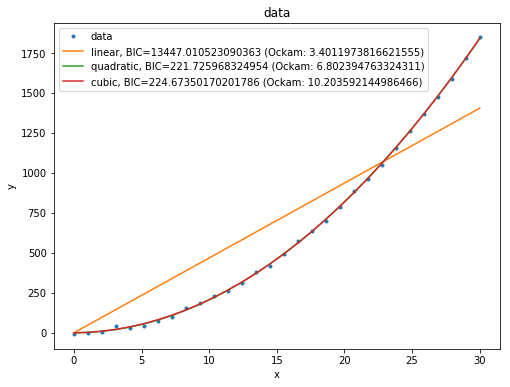

In [127]:
# Generate data
sigma_n = 10
x = np.linspace(0, 30, 30).reshape((-1, 1))
y = 1*x+2*x**2+np.random.normal(loc=0, scale=sigma_n, size=x.shape)

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(x, y, linestyle='none', marker='.', label='data')
plt.title('data')
plt.xlabel('x')
plt.ylabel('y')

import statsmodels.api as sm
from scipy.stats import norm

# Define the required functions for the models
def log_like(param, data_endog, data_exog):
    return np.sum(norm.logpdf(data_endog, loc = np.matmul(data_exog, param.reshape((-1, 1))), scale = sigma_n))
def max_log_like(data_endog, data_exog):
    y = data_endog.reshape((data_endog.shape[0],))
    ols = sm.OLS(endog = y, exog = data_exog)
    results = ols.fit()
    return results.params, log_like(results.params, data_endog, data_exog)

models = ['linear', 'quadratic', 'cubic']
data_exog = [x, np.concatenate((x, x**2), axis=1), np.concatenate((x, x**2, x**3), axis=1)]
BICs = []
params = []
for i, model in enumerate(models):
    param, loglike = max_log_like(y, data_exog[i])
    param = param.reshape((-1, 1))
    params.append(param)
    BICs.append(np.log(y.shape[0])*param.shape[0]-2*loglike)
    
    plt.plot(x, np.matmul(data_exog[i],params[i]), 
             label=model+', BIC={} (Ockam: {})'.format(BICs[i],np.log(y.shape[0])*param.shape[0]))
    
plt.legend()
plt.show()

Questions:
    - AICc is for small size data set, also it seems that its equation depends on the model (linear in the parameters and gaussian errors), thus I would not use it as a default choice
    - outputting delta seems redundant, should we output the penalization/model fit term?
    - do I do the model thingy? I would have a class model, BIC and so on would be an attribute of the model, not the regressor